In [87]:
from collections import defaultdict
# from pyquil.api import SyncConnection
from referenceqvm.api import SyncConnection
import numpy as np
import pyquil as pq
from itertools import product as cartesian_product
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Circuits for assignment probability measurements and tomography

In [203]:
def default_rotations_1q(q):
    """
    Generate the QUIL programs for tomographic pre- and post-rotations
    of a single qubit.
    """
    for g in ["I", "X-HALF", "Y-HALF", "X"]:
        p = pq.quil.Program()
        p.inst(pq.quil.Gate(g, (), [pq.quilbase.unpack_qubit(q)]))
        yield p

def default_rotations(*qubits):
    """
    Generate the QUIL programs for the tomographic pre- and post-rotations
    of any number of qubits.
    """
    for programs in cartesian_product(*(default_rotations_1q(q) for q in qubits)):
        p = pq.quil.Program()
        for pp in programs:
            p.inst(pp)
        yield p

        
def state_tomography_programs(state_prep, qubits=None, rotation_generator=default_rotations):
    """
    Yield tomographic sequences that prepare a state with QUIL program `state_prep`
    and then append tomographic rotations on the specified `qubits`.
    
    If `qubits is None`, it assumes all qubits in the program should be 
    tomographically rotated.
    """
    if qubits is None:
        qubits = state_prep.extract_qubits()
    for tp in rotation_generator(*qubits):
        p = pq.quil.Program()
#         p.inst(*TOMO_DEFCIRCUTS)
        p.inst(state_prep)
        p.inst(tp)
        yield p

def process_tomography_programs(proc, qubits=None, 
                                pre_rotation_generator=default_rotations,
                                post_rotation_generator=default_rotations
                               ):
    """
    Yield tomographic sequences that wrap a process encoded by a QUIL program `proc`
    in tomographic rotations on the specified `qubits`.
    
    If `qubits is None`, it assumes all qubits in the program should be 
    tomographically rotated.
    """
    if qubits is None:
        qubits = proc.extract_qubits()
    for tp_pre in pre_rotation_generator(*qubits):
        for tp_post in post_rotation_generator(*qubits):
            p = pq.quil.Program()
            p.inst(tp_pre)
            p.inst(proc)
            p.inst(tp_post)
            yield p

def basis_state_preps(*qubits):
    """
    Generate a sequence of programs that prepares the measurement
    basis states of some set of qubits in the order such that the qubit
    with highest index is iterated over the most quickly:
    E.g., for qubits=(0, 1), it returns the circuits::
    
        I_0 I_1
        I_0 X_1
        X_0 I_1
        X_0 X_1
    """
    for prep in cartesian_product(["I", "X"], repeat=len(qubits)):
        p = pq.quil.Program()
        for g, q in zip(prep, qubits):
            p.inst(pq.gates.Gate(g, (), [pq.quilbase.unpack_qubit(q)]))
        yield p

In [16]:
# PAULI OPS
X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()
I = qt.qeye(2)

TOMOGRAPHY_GATES = {
    "X-HALF": (-1j * np.pi / 4 * X).expm(),
    "Y-HALF": (-1j * np.pi / 4 * Y).expm(),
    "X": (-1j * np.pi / 2 * X).expm(),
    "Y": (-1j * np.pi / 2 * Y).expm(),
    "MINUS-X-HALF": (1j * np.pi / 4 * X).expm(),
    "MINUS-Y-HALF": (1j * np.pi / 4 * Y).expm(),
    "MINUS-X": (1j * np.pi / 2 * X).expm(),
    "MINUS-Y": (1j * np.pi / 2 * Y).expm(),
    "I": qt.qeye(2)
}


In [194]:
TOMO_DEFCIRCUTS = [
    pq.quil.DefGate(n, m.data.toarray())
    for n, m in TOMOGRAPHY_GATES.items()
]

In [198]:
print TOMO_DEFCIRCUTS[0].out()

DEFGATE X-HALF:
    0.70710678118654757+0.0i, 0.0-0.70710678118654757i
    0.0-0.70710678118654757i, 0.70710678118654757+0.0i



# Inverse sampling

In [113]:
def sample_outcomes(probs, n):
    """
    For a discrete probability distribution ``probs`` with outcomes
        0, 1, ..., k-1
    draw ``n`` random samples.
    """
    dist = np.cumsum(probs)
    outcomes = np.zeros(n, dtype=int)
    r = np.random.rand(n)
    for idx in range(n):
        outcomes[idx] = (np.where(r[idx] < dist)[0][0])
    return outcomes
    

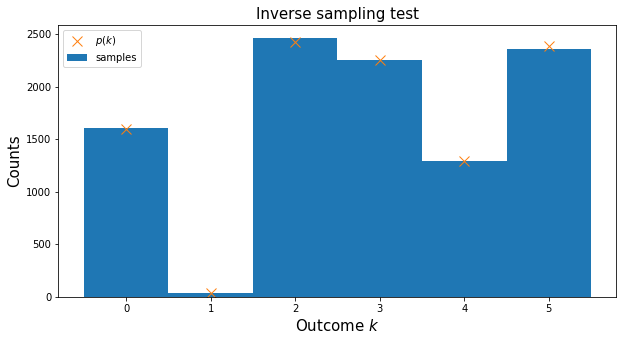

In [116]:
n = 6
N = 10000

probs = np.random.rand(n)
probs /= probs.sum()

samples = sample_outcomes(probs, N)
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=np.arange(n+1)-.5, label="samples")
plt.plot(probs * N, "x", ms=10, label="$p(k)$")
plt.title("Inverse sampling test", size=15)
plt.ylabel("Counts", size=15)
plt.xlabel("Outcome $k$", size=15)
plt.legend(loc="best")


In [204]:
cxn = SyncConnection(gate_set=TOMOGRAPHY_GATES)

# Simulate bad readout and estimate confusion matrix 

In [188]:
def sample_bad_readout(program, n, assignment_probs):
    cxn.run(program)
    return sample_outcomes(assignment_probs.dot(abs(cxn.wf.ravel())**2), n)

In [189]:
def make_histogram(samples, ksup):
    return np.histogram(samples, np.arange(ksup + 1) - 0.5)[0]

In [190]:
def estimate_assignment_probs(qubits, real_assignment_probs, n):
    estimated_assignment_probs = np.zeros((2**len(qubits), 2**len(qubits)))
    for jj, prog in enumerate(basis_state_preps(*qubits)):
        outcomes = sample_bad_readout(prog, n, real_assignment_probs)
        estimated_assignment_probs[:, jj] =  make_histogram(outcomes, 2**len(qubits)) / float(n)
    return estimated_assignment_probs

In [191]:
BAD_1Q_READOUT = np.array([[.9, .15],
                           [.1, .85]])
estimate_assignment_probs([0], BAD_1Q_READOUT, 200)

array([[ 0.89 ,  0.135],
       [ 0.11 ,  0.865]])

In [25]:
qt.tensor(X)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.  1.]
 [ 1.  0.]]

In [178]:
def quil_to_operator(program):
    """
    Convert a proto-Quil program consisting only of single qubit gates that appear in
    ``TOMOGRAPHY-GATES`` to a ``qutip.Qobj operator``.

    :param pyquil.quil.Program program: The program to convert.
    :return: A unitary operator representation.
    :rtype: qutip.Qobj
    """

    qubits = sorted(q for q in program.extract_qubits())
    U = qt.qeye([2] * len(qubits))

    for g in program.synthesize():

        if not isinstance(g, pq.gates.Gate):
            raise ValueError("Unsupported Instruction: %s" % g)

        if not len(g.arguments) == 1:
            raise ValueError("Only programs comprised of single qubit gates supported: %s" % g)

        qt_op = TOMOGRAPHY_GATES[g.operator_name]

        ops = [I] * len(qubits)
        idx = qubits.index(g.arguments[0].index())
        ops[idx] = qt_op

        U = qt.tensor(*ops) * U
    return U

In [50]:
qb = p.synthesize()[0].arguments[0]

In [56]:
for p in basis_state_preps(0, 1):
    print(p)

I 0
I 1

I 0
X 1

X 0
I 1

X 0
X 1



In [179]:
for p in default_rotations_1q(0):
    print(p)
    display(quil_to_operator(p))

I 0



Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0.  1.]]

X-HALF 0



Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.j          0.00000000-0.70710678j]
 [ 0.00000000-0.70710678j  0.70710678+0.j        ]]

Y-HALF 0



Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

X 0



Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.+0.j  0.-1.j]
 [ 0.-1.j  0.+0.j]]

In [180]:
for p in default_rotations(0, 1):
    print(p)
    display(quil_to_operator(p))

I 0
I 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]

I 0
X-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.j          0.00000000-0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000-0.70710678j  0.70710678+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.70710678+0.j
   0.00000000-0.70710678j]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000-0.70710678j
   0.70710678+0.j        ]]

I 0
Y-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678 -0.70710678  0.          0.        ]
 [ 0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.          0.70710678 -0.70710678]
 [ 0.          0.          0.70710678  0.70710678]]

I 0
X 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j  0.-1.j  0.+0.j  0.+0.j]
 [ 0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.-1.j]
 [ 0.+0.j  0.+0.j  0.-1.j  0.+0.j]]

X-HALF 0
I 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678+0.j          0.00000000+0.j          0.00000000-0.70710678j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.70710678+0.j          0.00000000+0.j
   0.00000000-0.70710678j]
 [ 0.00000000-0.70710678j  0.00000000+0.j          0.70710678+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000-0.70710678j  0.00000000+0.j
   0.70710678+0.j        ]]

X-HALF 0
X-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j   0.0-0.5j  0.0-0.5j -0.5+0.j ]
 [ 0.0-0.5j  0.5+0.j  -0.5+0.j   0.0-0.5j]
 [ 0.0-0.5j -0.5+0.j   0.5+0.j   0.0-0.5j]
 [-0.5+0.j   0.0-0.5j  0.0-0.5j  0.5+0.j ]]

X-HALF 0
Y-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j  -0.5+0.j   0.0-0.5j  0.0+0.5j]
 [ 0.5+0.j   0.5+0.j   0.0-0.5j  0.0-0.5j]
 [ 0.0-0.5j  0.0+0.5j  0.5+0.j  -0.5+0.j ]
 [ 0.0-0.5j  0.0-0.5j  0.5+0.j   0.5+0.j ]]

X-HALF 0
X 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.00000000+0.j          0.00000000-0.70710678j  0.00000000+0.j
  -0.70710678+0.j        ]
 [ 0.00000000-0.70710678j  0.00000000+0.j         -0.70710678+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j         -0.70710678+0.j          0.00000000+0.j
   0.00000000-0.70710678j]
 [-0.70710678+0.j          0.00000000+0.j          0.00000000-0.70710678j
   0.00000000+0.j        ]]

Y-HALF 0
I 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.70710678  0.         -0.70710678  0.        ]
 [ 0.          0.70710678  0.         -0.70710678]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.70710678  0.          0.70710678]]

Y-HALF 0
X-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j   0.0-0.5j -0.5+0.j   0.0+0.5j]
 [ 0.0-0.5j  0.5+0.j   0.0+0.5j -0.5+0.j ]
 [ 0.5+0.j   0.0-0.5j  0.5+0.j   0.0-0.5j]
 [ 0.0-0.5j  0.5+0.j   0.0-0.5j  0.5+0.j ]]

Y-HALF 0
Y-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.5 -0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5  0.5  0.5]]

Y-HALF 0
X 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j          0.-0.70710678j  0.+0.j          0.+0.70710678j]
 [ 0.-0.70710678j  0.+0.j          0.+0.70710678j  0.+0.j        ]
 [ 0.+0.j          0.-0.70710678j  0.+0.j          0.-0.70710678j]
 [ 0.-0.70710678j  0.+0.j          0.-0.70710678j  0.+0.j        ]]

X 0
I 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j  0.+0.j  0.-1.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.-1.j]
 [ 0.-1.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-1.j  0.+0.j  0.+0.j]]

X 0
X-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.00000000+0.j          0.00000000+0.j          0.00000000-0.70710678j
  -0.70710678+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j         -0.70710678+0.j
   0.00000000-0.70710678j]
 [ 0.00000000-0.70710678j -0.70710678+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [-0.70710678+0.j          0.00000000-0.70710678j  0.00000000+0.j
   0.00000000+0.j        ]]

X 0
Y-HALF 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j          0.+0.j          0.-0.70710678j  0.+0.70710678j]
 [ 0.+0.j          0.+0.j          0.-0.70710678j  0.-0.70710678j]
 [ 0.-0.70710678j  0.+0.70710678j  0.+0.j          0.+0.j        ]
 [ 0.-0.70710678j  0.-0.70710678j  0.+0.j          0.+0.j        ]]

X 0
X 1



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [-1.  0.  0.  0.]]

In [201]:
state_prep = pq.quil.Program()
state_prep.inst(pq.gates.X(0))
state_prep.inst(pq.gates.Y(1))

for p in state_tomography_programs(state_prep):
    print(p)

DEFGATE X-HALF:
    0.70710678118654757+0.0i, 0.0-0.70710678118654757i
    0.0-0.70710678118654757i, 0.70710678118654757+0.0i

DEFGATE MINUS-Y-HALF:
    0.70710678118654757+0.0i, 0.70710678118654757+0.0i
    -0.70710678118654746+0.0i, 0.70710678118654757+0.0i

DEFGATE Y-HALF:
    0.70710678118654757+0.0i, -0.70710678118654757+0.0i
    0.70710678118654746+0.0i, 0.70710678118654757+0.0i

DEFGATE I:
    1.0+0.0i, 0.0+0.0i
    0.0+0.0i, 1.0+0.0i

DEFGATE MINUS-Y:
    0.0+0.0i, 1.0+0.0i
    -1.0+0.0i, 0.0+0.0i

DEFGATE MINUS-X-HALF:
    0.70710678118654757+0.0i, 0.0+0.70710678118654757i
    0.0+0.70710678118654757i, 0.70710678118654757+0.0i

DEFGATE Y:
    0.0+0.0i, -1.0+0.0i
    1.0+0.0i, 0.0+0.0i

DEFGATE X:
    0.0+0.0i, 0.0-1.0i
    0.0-1.0i, 0.0+0.0i

DEFGATE MINUS-X:
    0.0+0.0i, 0.0+1.0i
    0.0+1.0i, 0.0+0.0i

X 0
Y 1
I 0
I 1

DEFGATE X-HALF:
    0.70710678118654757+0.0i, 0.0-0.70710678118654757i
    0.0-0.70710678118654757i, 0.70710678118654757+0.0i

DEFGATE MINUS-Y-HALF:
    0.70

In [6]:
state_prep = pq.quil.Program()
state_prep.inst(pq.gates.X(0))

for p in process_tomography_programs(state_prep):
    print(p)

I 0
X 0
I 0

I 0
X 0
X-HALF 0

I 0
X 0
Y-HALF 0

I 0
X 0
X 0

X-HALF 0
X 0
I 0

X-HALF 0
X 0
X-HALF 0

X-HALF 0
X 0
Y-HALF 0

X-HALF 0
X 0
X 0

Y-HALF 0
X 0
I 0

Y-HALF 0
X 0
X-HALF 0

Y-HALF 0
X 0
Y-HALF 0

Y-HALF 0
X 0
X 0

X 0
X 0
I 0

X 0
X 0
X-HALF 0

X 0
X 0
Y-HALF 0

X 0
X 0
X 0



In [7]:
l1 = list(process_tomography_programs(state_prep))
l2 = list(process_tomography_programs(state_prep))

In [205]:
TOMOGRAPHY_GATES

{'I': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0.  1.]],
 'MINUS-X': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.+0.j  0.+1.j]
  [ 0.+1.j  0.+0.j]],
 'MINUS-X-HALF': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.70710678+0.j          0.00000000+0.70710678j]
  [ 0.00000000+0.70710678j  0.70710678+0.j        ]],
 'MINUS-Y': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.  1.]
  [-1.  0.]],
 'MINUS-Y-HALF': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.70710678  0.70710678]
  [-0.70710678  0.70710678]],
 'X': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
 Qobj data =
 [[ 0.+0.j  0.-1.j]
  [ 0.-1.j  0.+0.j]],
 'X-HALF': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, ishe

In [211]:
cxn = SyncConnection(gate_set={k: v.data.toarray() for k, v in TOMOGRAPHY_GATES.items()})

In [219]:
from grove.benchmarking.operator_utils import POVM_PI_BASIS, make_diagonal_povm
from grove.benchmarking.tomography import StateTomography, ProcessTomography, DEFAULT_STATE_TOMO_SETTINGS

In [224]:
prog = pq.quil.Program(pq.gates.Gate("Y-HALF", (), [pq.quilbase.unpack_qubit(0)]))
nq = 1
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(state_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0], BAD_1Q_READOUT, nsamples)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_1Q_READOUT), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]

In [225]:
histograms

array([[ 521.,  479.],
       [ 542.,  458.],
       [ 133.,  867.],
       [ 531.,  469.]])

In [226]:
state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops, DEFAULT_STATE_TOMO_SETTINGS)

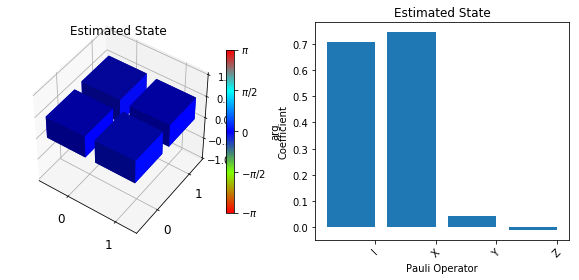

In [227]:
state_tomo.plot();